In [2]:
# Importar modulos a emplear
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sys
import os

# Agregar la carpeta raíz del proyecto a las rutas de búsqueda de Python
base_dir = os.getcwd()  # Obtiene el directorio actual (donde está la libreta)
sys.path.append(base_dir)  # Agrega la carpeta raíz del proyecto a las rutas de búsqueda

# Importar las funciones desde helpers.importar_data
from helpers.visualizaciones import crear_heatmap_beneficio, visualizar_beneficios_interactivo, graficar_distribucion

# Definir la ruta base y cargar los datos limpios
base_dir = os.getcwd()
procesados_dir = os.path.join(base_dir, "data", "procesados")

# Importamos el dato limpio

In [3]:
# Cargar los datos limpios
ventas_df = pd.read_csv(os.path.join(procesados_dir, "ventas_limpio.csv"))
productos_df = pd.read_csv(os.path.join(procesados_dir, "productos_limpio.csv"))
ciudad_df = pd.read_csv(os.path.join(procesados_dir, "ciudad_limpio.csv"))

# Union de tablas

In [4]:
# Unir las tablas
# Unir ventas con productos (por Cod_Producto)
ventas_productos = pd.merge(ventas_df, productos_df, on="cod_producto")

# Unir el resultado con ciudad (por Cod_Ciudad)
ventas_completa = pd.merge(ventas_productos, ciudad_df, on="cod_ciudad")

In [5]:
# Calcular ingresos, costos y beneficios
ventas_completa["Ingresos"] = ventas_completa["precio_unitario"] * ventas_completa["unidades_vendidas"]
ventas_completa["Costo_Total"] = (
    (ventas_completa["costo_unitario"] * ventas_completa["unidades_vendidas"])
    + ventas_completa["costo_asociado_al_domicilio"]
)
ventas_completa["Beneficio"] = ventas_completa["Ingresos"] - ventas_completa["Costo_Total"]

# Resumen total
resumen_total = ventas_completa[["Ingresos", "Costo_Total", "Beneficio"]].sum()
print("Resumen Total del Negocio:")
print(resumen_total)

Resumen Total del Negocio:
Ingresos       27635500.0
Costo_Total     5231050.0
Beneficio      22404450.0
dtype: float64


# Graficas

## Heatmaps

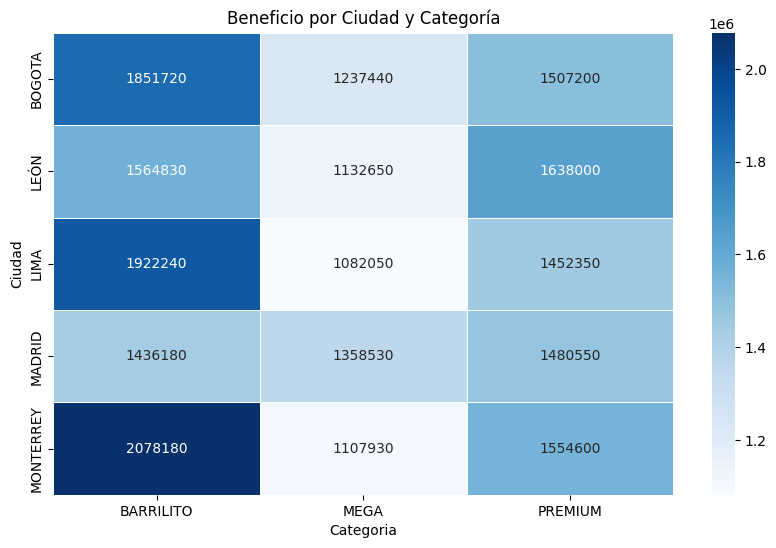

In [6]:
# Beneficio por ciudad y categoria
crear_heatmap_beneficio(
    ventas_completa,
    index="ciudad",
    columns="categoria",
    values="Beneficio",
    titulo="Beneficio por Ciudad y Categoría"
)

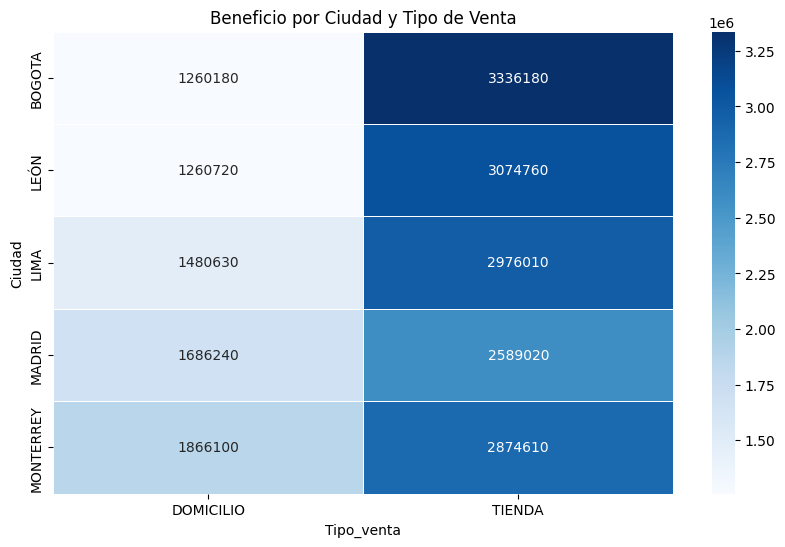

In [7]:
# Beneficio por ciudad y tipo de venta
crear_heatmap_beneficio(
    ventas_completa,
    index="ciudad",
    columns="tipo_venta",
    values="Beneficio",
    titulo="Beneficio por Ciudad y Tipo de Venta"
)

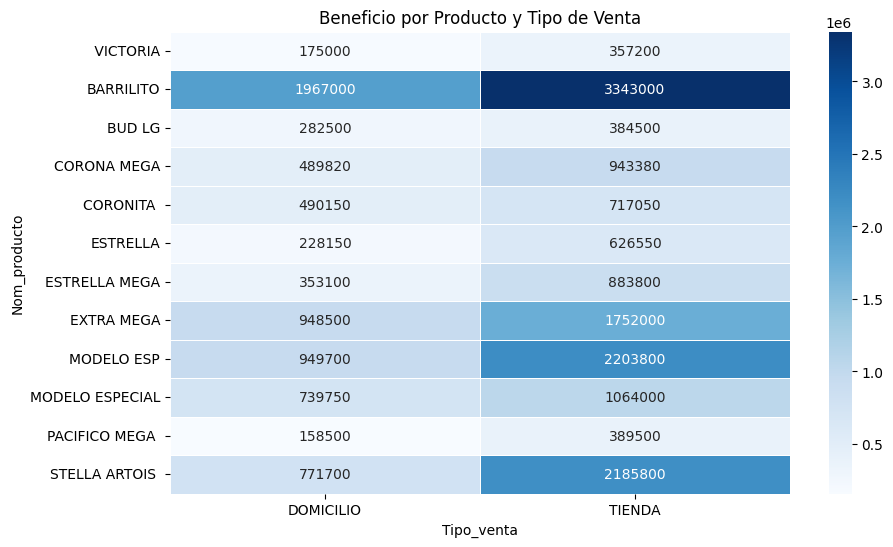

In [8]:
# Beneficio por producto y tipo de venta
crear_heatmap_beneficio(
    ventas_completa,
    index="nom_producto",
    columns="tipo_venta",
    values="Beneficio",
    titulo="Beneficio por Producto y Tipo de Venta"
)

## Distribución de beneficios

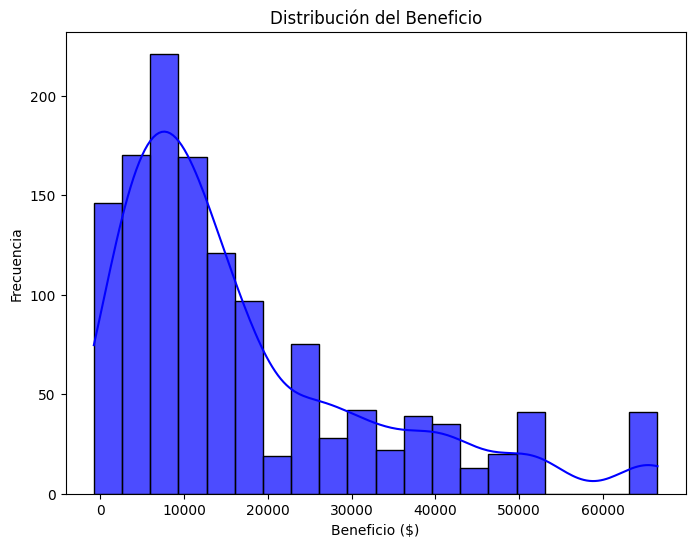

In [9]:
# Graficar la distribución del beneficio
graficar_distribucion(ventas_completa, columna="Beneficio", titulo="Distribución del Beneficio")

**Beneficio bajo dominante**
* La mayoría de las transacciones tienen un beneficio bajo (aproximadamente entre 0 y 10,000).
* Esto podría deberse a productos de menor precio o márgenes estrechos.

**Beneficios medianos**
* Hay una disminución en la frecuencia de transacciones con beneficios entre 20,000 y 40,000, pero aún es considerable.

**Beneficios extremos**

Las transacciones con beneficios muy altos (>40,000) son escasas pero existen, probablemente impulsadas por:
 * Ventas de productos de alto valor.
 * Pedidos con un alto volumen de unidades.

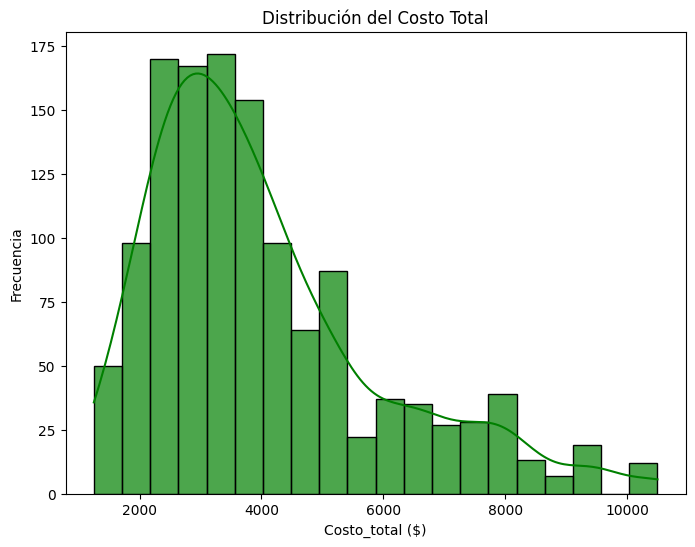

In [12]:
# Graficar la distribucion del Costo Total
graficar_distribucion(ventas_completa, columna="Costo_Total", titulo="Distribución del Costo Total", color="green")

## Investigar beneficios negativos

In [10]:
# Filtrar transacciones con beneficios negativos
beneficios_negativos = ventas_completa[ventas_completa["Beneficio"] < 0]

Vamos a resolver las siguientes preguntas:
* ¿Hay productos específicos que generan pérdidas?
* ¿Hay ciudades donde los costos de envío son desproporcionados?

In [11]:
# Beneficios negativos por producto
print(beneficios_negativos.groupby("nom_producto")[["Beneficio"]].sum())

# Beneficios negativos por ciudad
print(beneficios_negativos.groupby("ciudad")[["Beneficio"]].sum())

                Beneficio
nom_producto             
 VICTORIA         -4620.0
BUD LG             -600.0
PACIFICO MEGA     -2250.0
        Beneficio
ciudad           
BOGOTA    -7470.0


Podemos observar que solo en la ciudad de BOGOTA existen perdidas en tres productos:
* VICTORIA
* BUD LG
* PACHIFICO MEGA

* ¿Las transacciones con beneficio negativo tienen costos inesperadamente altos o ingresos muy bajos?

In [12]:
print(beneficios_negativos[["Ingresos", "Costo_Total", "Beneficio", "unidades_vendidas"]].describe())

          Ingresos  Costo_Total   Beneficio  unidades_vendidas
count    12.000000    12.000000   12.000000               12.0
mean   2641.666667  3264.166667 -622.500000                1.0
std     172.986249    17.298625  155.687624                0.0
min    2500.000000  3250.000000 -750.000000                1.0
25%    2575.000000  3257.500000 -682.500000                1.0
50%    2600.000000  3260.000000 -660.000000                1.0
75%    2600.000000  3260.000000 -660.000000                1.0
max    3000.000000  3300.000000 -300.000000                1.0


**Altos costos fijos en Bogotá**
* Es probable que el costo de envío fijo de 3000 para Bogotá sea desproporcionado en relación con los ingresos por venta, especialmente en productos de menor precio.

Márgenes bajos en productos específicos:
* Productos como VICTORIA y PACIFICO MEGA podrían tener márgenes muy bajos, lo que amplifica el impacto de los costos de envío.

**Acciones recomendadas**

Revisar el modelo de costos en Bogotá:

Si los costos de envío son altos y fijos, considera estrategias como:
* Aplicar un cargo adicional para pedidos pequeños.
* Ofrecer descuentos solo en ciudades con costos de envío más bajos.

Revisar precios o márgenes de productos con pérdidas:
* Analiza si los precios de productos como VICTORIA y PACIFICO MEGA deben ajustarse para cubrir los costos asociados.

Segmentar ventas por tamaño del pedido:
* Considera ofrecer incentivos (como envío gratuito) solo para pedidos de varias unidades o con un ingreso mínimo.


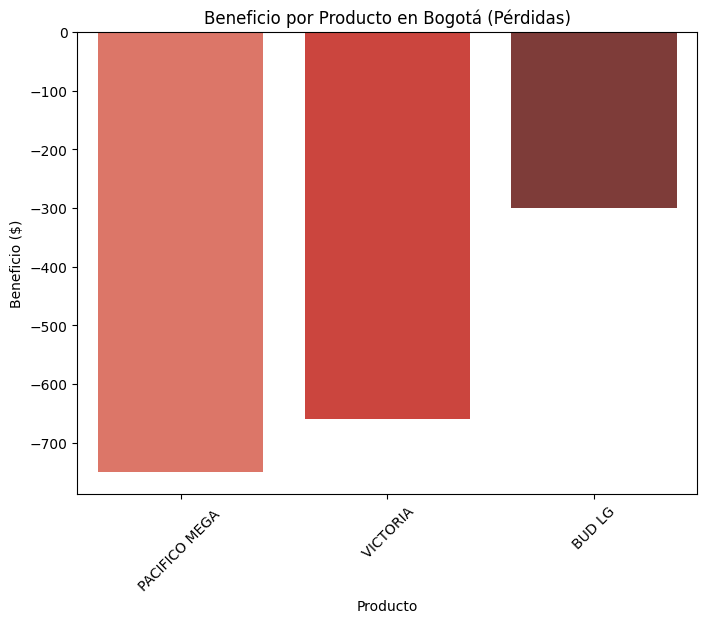

In [13]:
# Filtrar datos de Bogotá
bogota_negativos = beneficios_negativos[beneficios_negativos["ciudad"] == "BOGOTA"]

plt.figure(figsize=(8, 6))
sns.barplot(
    data=bogota_negativos, 
    x="nom_producto", 
    y="Beneficio", 
    hue="nom_producto",  # Asignar la variable para colores
    palette="Reds_d", 
    dodge=False  # Asegura que las barras no estén separadas
)
plt.legend([], [], frameon=False)  # Desactiva la leyenda
plt.title("Beneficio por Producto en Bogotá (Pérdidas)")
plt.xlabel("Producto")
plt.ylabel("Beneficio ($)")
plt.xticks(rotation=45)
plt.show()

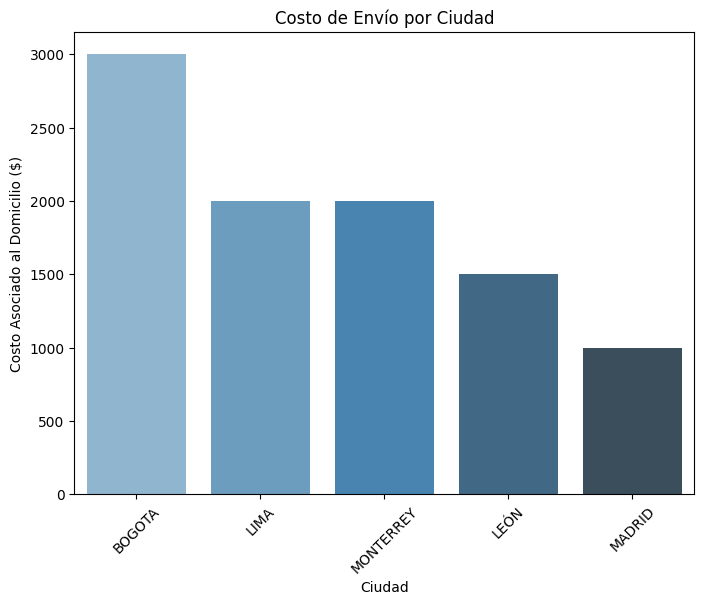

In [14]:
# Comparar costos de envío entre ciudades
costos_envio = ciudad_df[["ciudad", "costo_asociado_al_domicilio"]].sort_values(by="costo_asociado_al_domicilio", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=costos_envio,
    x="ciudad",
    y="costo_asociado_al_domicilio",
    hue="ciudad",  # Asigna la variable x como hue
    palette="Blues_d",
    dodge=False  # Asegura que las barras no estén separadas
)
plt.legend([], [], frameon=False)  # Desactiva la leyenda
plt.title("Costo de Envío por Ciudad")
plt.xlabel("Ciudad")
plt.ylabel("Costo Asociado al Domicilio ($)")
plt.xticks(rotation=45)
plt.show()

# Beneficios a lo largo del tiempo

In [15]:
# Beneficios por ciudad
visualizar_beneficios_interactivo(ventas_completa, agrupador="ciudad", titulo="Beneficios por Ciudad")

In [16]:
# Beneficios por producto
visualizar_beneficios_interactivo(ventas_completa, agrupador="nom_producto", titulo="Beneficios por Producto")

In [17]:
# Beneficios por tipo de venta
visualizar_beneficios_interactivo(ventas_completa, agrupador="tipo_venta", titulo="Beneficios por Tipo de Venta")

In [18]:
# Beneficios por tipo de categoria
visualizar_beneficios_interactivo(ventas_completa, agrupador="categoria", titulo="Beneficios por Categoría")